# How to identify gentrified areas?

1. measure both housing price increases and changes in deprivation levels. 
2. calculate the **percentage increase** in average housing prices for each area over the five-year period
3. use the IMD to assess whether the area's deprivation level has improved—measured by a drop in IMD decile scores

Areas where **both** house prices and IMD scores rose faster than average are flagged as likely to be experiencing gentrification.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [2]:
import sys
print(sys.executable)

e:\dissertation\project\housing_feature_gentrification\venv\Scripts\python.exe


## House price

In [3]:
# reading house price
house_path = "data/gentri_data/HPSSA_Dataset_46_Median_price_paid_for_residential_properties_by_LSOA.xls"
house_price = pd.ExcelFile(house_path)

In [4]:
# reading sheet
df_house = house_price.parse(sheet_name="1a", header = 5) 
df_house.head()

Local authority code Local authority name  LSOA code        LSOA name  \
0            E06000001           Hartlepool  E01011949  Hartlepool 009A   
1            E06000001           Hartlepool  E01011950  Hartlepool 008A   
2            E06000001           Hartlepool  E01011951  Hartlepool 007A   
3            E06000001           Hartlepool  E01011952  Hartlepool 002A   
4            E06000001           Hartlepool  E01011953  Hartlepool 002B   

  Year ending Dec 1995 Year ending Mar 1996 Year ending Jun 1996  \
0                34750                34500                30500   
1                25000                25000                25300   
2                27000                27000                27250   
3                44500                44500                30000   
4                22000                27000                27000   

  Year ending Sep 1996 Year ending Dec 1996 Year ending Mar 1997  ...  \
0                30000                29950                29000  ...   
1                25625                25000                24800  ...   
2                28950                28500                28950  ...   
3                26675                26000                25500  ...   
4                20600                20000                19500  ...   

  Year ending Dec 2020 Year ending Mar 2021 Year ending Jun 2021  \
0                88000                81500                80500   
1                29750                33000                47000   
2                50000                51500                53000   
3                85000                    :                83500   
4                    :                    :                    :   

  Year ending Sep 2021 Year ending Dec 2021 Year ending Mar 2022  \
0                89000               101500                94500   
1                49999                50159                50159   
2              58573.5                60000                62999   
3                83000                80000                76000   
4                95000                92500                95000   

  Year ending Jun 2022 Year ending Sep 2022 Year ending Dec 2022  \
0               113000                97500               102500   
1                46000                43500                42000   
2              61499.5                60000              65499.5   
3                75000                75000                70000   
4                95000                92500                93750   

  Year ending Mar 2023  
0               106500  
1                43500  
2                66000  
3                60000  
4                92500  

[5 rows x 114 columns]

In [5]:
# select the column that's needed
house_columns_needed = ['LSOA code', 'LSOA name', 
                        'Year ending Dec 2010', 'Year ending Sep 2010', 'Year ending Jun 2010', 'Year ending Mar 2010',
                        'Year ending Dec 2019', 'Year ending Sep 2019', 'Year ending Jun 2019', 'Year ending Mar 2019'] 
df_house_select = df_house[house_columns_needed]
df_house_select.head()

LSOA code        LSOA name Year ending Dec 2010 Year ending Sep 2010  \
0  E01011949  Hartlepool 009A                85000                84000   
1  E01011950  Hartlepool 008A                56750                52000   
2  E01011951  Hartlepool 007A                57000                57000   
3  E01011952  Hartlepool 002A                97890                84945   
4  E01011953  Hartlepool 002B                45000                45000   

  Year ending Jun 2010 Year ending Mar 2010 Year ending Dec 2019  \
0                87500                85000                77000   
1                52000                55000                27500   
2                57000                57000              39997.5   
3                47000                68500                66475   
4                65000                65000                58000   

  Year ending Sep 2019 Year ending Jun 2019 Year ending Mar 2019  
0                77500                77500                73250  
1                27000                29500                28000  
2                42800                46250                50000  
3                70000                70000                70000  
4                62000                59000                66000

In [6]:
# read in lsoa shapefile
london_gdf = gpd.read_file("data/statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp")

# extract lsoa11cd as LSOA list
london_lsoa_list = london_gdf['LSOA11CD'].unique()

In [7]:
# select data in London area
df_london_price = df_house_select[df_house_select['LSOA code'].isin(london_lsoa_list)]
df_london_price.dtypes

LSOA code               object
LSOA name               object
Year ending Dec 2010    object
Year ending Sep 2010    object
Year ending Jun 2010    object
Year ending Mar 2010    object
Year ending Dec 2019    object
Year ending Sep 2019    object
Year ending Jun 2019    object
Year ending Mar 2019    object
dtype: object

In [9]:
# turn object into float
columns_to_convert = [
    'Year ending Mar 2010', 'Year ending Jun 2010',
    'Year ending Sep 2010', 'Year ending Dec 2010',
    'Year ending Mar 2019', 'Year ending Jun 2019',
    'Year ending Sep 2019', 'Year ending Dec 2019'
]

df_london_price[columns_to_convert] = (df_london_price[columns_to_convert].apply(pd.to_numeric, errors='coerce'))

C:\Users\hp\AppData\Local\Temp\ipykernel_18772\2152935794.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price[columns_to_convert] = (df_london_price[columns_to_convert].apply(pd.to_numeric, errors='coerce'))


In [10]:
# calculating the mean of 2015 and 2019
df_london_price['2010'] = df_london_price[[
    'Year ending Mar 2010', 'Year ending Jun 2010',
    'Year ending Sep 2010', 'Year ending Dec 2010'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price['2019'] = df_london_price[[
    'Year ending Mar 2019', 'Year ending Jun 2019',
    'Year ending Sep 2019', 'Year ending Dec 2019'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

C:\Users\hp\AppData\Local\Temp\ipykernel_18772\2770441617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price['2010'] = df_london_price[[
C:\Users\hp\AppData\Local\Temp\ipykernel_18772\2770441617.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price['2019'] = df_london_price[[


In [11]:
# calculating the chage(Relative Growth Rate) percentage between 2015 to 2019
df_london_price.loc[:, 'price_growth'] = (df_london_price['2019'] - df_london_price['2010']) / df_london_price['2010']
df_london_price.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_18772\2753107683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price.loc[:, 'price_growth'] = (df_london_price['2019'] - df_london_price['2010']) / df_london_price['2010']


LSOA code            LSOA name  Year ending Dec 2010  \
28009  E01000001  City of London 001A              499475.0   
28010  E01000002  City of London 001B              525000.0   
28011  E01000003  City of London 001C              325000.0   
28012  E01000005  City of London 001E                   NaN   
28013  E01032739  City of London 001F              380000.0   

       Year ending Sep 2010  Year ending Jun 2010  Year ending Mar 2010  \
28009              499000.0              495000.0              482500.0   
28010              526250.0              502500.0              508500.0   
28011              315000.0              320000.0              316250.0   
28012                   NaN                   NaN              195000.0   
28013              385000.0              365000.0              362500.0   

       Year ending Dec 2019  Year ending Sep 2019  Year ending Jun 2019  \
28009              865000.0              887500.0              847500.0   
28010              862500.0              880000.0              857500.0   
28011              515000.0              572500.0              599000.0   
28012                   NaN                   NaN                   NaN   
28013             1500000.0              996075.0              941160.0   

       Year ending Mar 2019       2010        2019  price_growth  
28009              815000.0  493993.75   853750.00      0.728261  
28010              835000.0  515562.50   858750.00      0.665656  
28011              599500.0  319062.50   571500.00      0.791185  
28012                   NaN  195000.00         NaN           NaN  
28013              964500.0  373125.00  1100433.75      1.949236

### ! Important
price dataset has missing data

In [12]:
df_london_price.isna().sum()

LSOA code                 0
LSOA name                 0
Year ending Dec 2010    259
Year ending Sep 2010    242
Year ending Jun 2010    272
Year ending Mar 2010    339
Year ending Dec 2019    416
Year ending Sep 2019    437
Year ending Jun 2019    412
Year ending Mar 2019    396
2010                    138
2019                    204
price_growth            286
dtype: int64

In [13]:
# delete all the na data
df_house_price_cleaned = df_london_price.dropna(subset=['2010', '2019', 'price_growth'])
df_house_price_cleaned.shape

(4549, 13)

## IMD

- imd score: the larger the score, the more deprived the area (and the lower its rank)

- imd rank: the lower the rank, the more deprived the area

the rank is not isometric, one rank between different lsoas may not be the same, so i think it‘s better to use scores to calculate the rate

In [14]:
# read in imd data
# 2019
imd_2019 = pd.ExcelFile("data/gentri_data/File_5_-_IoD2019_Scores.xlsx")
df_imd_2019 = imd_2019.parse(sheet_name="IoD2019 Scores") 
df_imd_2019.head()

LSOA code (2011)           LSOA name (2011)  \
0        E01000001        City of London 001A   
1        E01000002        City of London 001B   
2        E01000003        City of London 001C   
3        E01000005        City of London 001E   
4        E01000006  Barking and Dagenham 016A   

  Local Authority District code (2019) Local Authority District name (2019)  \
0                            E09000001                       City of London   
1                            E09000001                       City of London   
2                            E09000001                       City of London   
3                            E09000001                       City of London   
4                            E09000002                 Barking and Dagenham   

   Index of Multiple Deprivation (IMD) Score  Income Score (rate)  \
0                                      6.208                0.007   
1                                      5.143                0.034   
2                                     19.402                0.086   
3                                     28.652                0.211   
4                                     19.837                0.117   

   Employment Score (rate)  Education, Skills and Training Score  \
0                    0.010                                 0.024   
1                    0.027                                 0.063   
2                    0.086                                 5.804   
3                    0.136                                22.260   
4                    0.059                                14.798   

   Health Deprivation and Disability Score  Crime Score  \
0                                   -1.654       -2.012   
1                                   -1.115       -2.343   
2                                   -0.102       -1.032   
3                                   -0.121       -1.317   
4                                   -0.359       -0.147   

   Barriers to Housing and Services Score  Living Environment Score  \
0                                  29.472                    31.873   
1                                  24.412                    23.084   
2                                  40.103                    40.535   
3                                  39.900                    28.979   
4                                  45.171                    26.888   

   Income Deprivation Affecting Children Index (IDACI) Score (rate)  \
0                                              0.006                  
1                                              0.037                  
2                                              0.052                  
3                                              0.209                  
4                                              0.155                  

   Income Deprivation Affecting Older People (IDAOPI) Score (rate)  \
0                                              0.012                 
1                                              0.030                 
2                                              0.128                 
3                                              0.322                 
4                                              0.162                 

   Children and Young People Sub-domain Score  Adult Skills Sub-domain Score  \
0                                      -2.107                          0.032   
1                                      -1.907                          0.034   
2                                      -0.292                          0.142   
3                                       0.338                          0.321   
4                                      -0.366                          0.325   

   Geographical Barriers Sub-domain Score  Wider Barriers Sub-domain Score  \
0                                  -0.430                            3.587   
1                                  -1.060                            3.231   
2                                  -0.691                      

In [15]:
# select *Index of Multiple Deprivation (IMD) Score* in London area
df_imd_2019_only = df_imd_2019[['LSOA code (2011)', 'LSOA name (2011)', 'Index of Multiple Deprivation (IMD) Score']]
df_imd_2019_only.head()

LSOA code (2011)           LSOA name (2011)  \
0        E01000001        City of London 001A   
1        E01000002        City of London 001B   
2        E01000003        City of London 001C   
3        E01000005        City of London 001E   
4        E01000006  Barking and Dagenham 016A   

   Index of Multiple Deprivation (IMD) Score  
0                                      6.208  
1                                      5.143  
2                                     19.402  
3                                     28.652  
4                                     19.837

In [16]:
df_london_imd_2019 = df_imd_2019_only[df_imd_2019_only['LSOA code (2011)'].isin(london_lsoa_list)]
df_london_imd_2019.shape

(4835, 3)

In [19]:
#2015
imd_2010 = pd.ExcelFile("data/gentri_data/2010imd.xls")
df_imd_2010 = imd_2010.parse(sheet_name="IMD 2010") 
df_imd_2010.head()

LSOA CODE LA CODE         LA NAME GOR CODE GOR NAME  IMD SCORE  \
0  E01000001    00AA  City of London        H   London   6.161637   
1  E01000002    00AA  City of London        H   London   5.585054   
2  E01000003    00AA  City of London        H   London  13.292920   
3  E01000004    00AA  City of London        H   London  11.171350   
4  E01000005    00AA  City of London        H   London  21.364660   

   RANK OF IMD SCORE (where 1 is most deprived)  
0                                         28814  
1                                         29450  
2                                         20047  
3                                         22503  
4                                         12978

In [158]:
df_imd_2010_only = df_imd_2010[['LSOA CODE', 'IMD SCORE']]
df_imd_2010_only.head()

LSOA CODE  IMD SCORE
0  E01000001   6.161637
1  E01000002   5.585054
2  E01000003  13.292920
3  E01000004  11.171350
4  E01000005  21.364660

In [159]:
df_london_imd_2010 = df_imd_2010_only[df_imd_2010_only['LSOA CODE'].isin(london_lsoa_list)]
df_london_imd_2010.shape

(4642, 2)

In [22]:
df_london_imd_2010.rename(columns={'LSOA CODE': 'LSOA code (2011)'}, inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_18772\2916280915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_imd_2010.rename(columns={'LSOA CODE': 'LSOA code (2011)'}, inplace=True)


In [25]:
# merge two dataframe
df_london_imd = pd.merge(
    df_london_imd_2010,
    df_london_imd_2019,
    on='LSOA code (2011)',
)

In [26]:
print(df_london_imd.columns)

Index(['LSOA code (2011)', 'IMD SCORE', 'LSOA name (2011)',
       'Index of Multiple Deprivation (IMD) Score'],
      dtype='object')


As the larger imd score means more deprived area is, we need to calculate the decrese between 2015 -2019 to represent the increase of the area. S here I use the date of 2015 to minus 2019.

In [27]:
# calculate improving rate
df_london_imd['imd_score_improve'] = (
    df_london_imd['IMD SCORE'] - 
    df_london_imd['Index of Multiple Deprivation (IMD) Score']
) / df_london_imd['IMD SCORE']

df_london_imd.head()

LSOA code (2011)  IMD SCORE           LSOA name (2011)  \
0        E01000001   6.161637        City of London 001A   
1        E01000002   5.585054        City of London 001B   
2        E01000003  13.292920        City of London 001C   
3        E01000005  21.364660        City of London 001E   
4        E01000006  17.077650  Barking and Dagenham 016A   

   Index of Multiple Deprivation (IMD) Score  imd_score_improve  
0                                      6.208          -0.007524  
1                                      5.143           0.079149  
2                                     19.402          -0.459574  
3                                     28.652          -0.341093  
4                                     19.837          -0.161577

In [157]:
df_london_imd.shape

(4642, 5)

## Gentrified areas

In [28]:
df_london_imd.rename(columns={'LSOA code (2011)': 'LSOA code'}, inplace=True)

In [29]:
df_london_all = pd.merge(
    df_house_price_cleaned,
    df_london_imd,
    on='LSOA code',
    how='inner'  # only keep the lsoa that have both data
)

In [30]:
# calculate the averages
mean_price_growth = df_london_all['price_growth'].mean()
mean_imd_improve = df_london_all['imd_score_improve'].mean()
# add labels
df_london_all['high_price_growth'] = df_london_all['price_growth'] > mean_price_growth
df_london_all['high_imd_improvement'] = df_london_all['imd_score_improve'] > mean_imd_improve
df_london_all.head()

LSOA code                  LSOA name  Year ending Dec 2010  \
0  E01000001        City of London 001A              499475.0   
1  E01000002        City of London 001B              525000.0   
2  E01000003        City of London 001C              325000.0   
3  E01000006  Barking and Dagenham 016A              241500.0   
4  E01000007  Barking and Dagenham 015A                   NaN   

   Year ending Sep 2010  Year ending Jun 2010  Year ending Mar 2010  \
0              499000.0              495000.0              482500.0   
1              526250.0              502500.0              508500.0   
2              315000.0              320000.0              316250.0   
3              230000.0              230000.0              221500.0   
4                   NaN              120500.0              131000.0   

   Year ending Dec 2019  Year ending Sep 2019  Year ending Jun 2019  \
0              865000.0              887500.0              847500.0   
1              862500.0              880000.0              857500.0   
2              515000.0              572500.0              599000.0   
3              210000.0              292500.0              205000.0   
4              227500.0              210000.0              207500.0   

   Year ending Mar 2019       2010      2019  price_growth  IMD SCORE  \
0              815000.0  493993.75  853750.0      0.728261   6.161637   
1              835000.0  515562.50  858750.0      0.665656   5.585054   
2              599500.0  319062.50  571500.0      0.791185  13.292920   
3              282000.0  230750.00  247375.0      0.072048  17.077650   
4              226500.0  125750.00  217875.0      0.732604  37.235280   

            LSOA name (2011)  Index of Multiple Deprivation (IMD) Score  \
0        City of London 001A                                      6.208   
1        City of London 001B                                      5.143   
2        City of London 001C                                     19.402   
3  Barking and Dagenham 016A                                     19.837   
4  Barking and Dagenham 015A                                     31.576   

   imd_score_improve  high_price_growth  high_imd_improvement  
0          -0.007524              False                 False  
1           0.079149              False                 False  
2          -0.459574               True                 False  
3          -0.161577              False                 False  
4           0.151987              False                  True

In [31]:
# identify gentrification
df_london_all['gentrified'] = df_london_all['high_price_growth'] & df_london_all['high_imd_improvement']
df_london_all['gentrified'].value_counts()

gentrified
False    3264
True     1103
Name: count, dtype: int64

In [32]:
# plot maps
# change the column name in shp
london_gdf.rename(columns={'LSOA11CD': 'LSOA code'}, inplace=True)

In [33]:
# merge data with shp
london_gdf_merged = london_gdf.merge(df_london_all, on='LSOA code', how='inner')

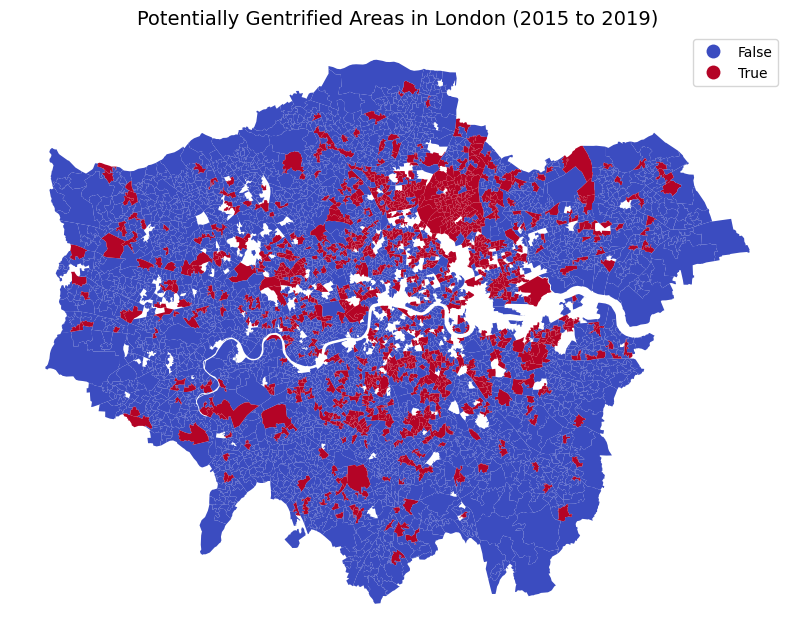

In [34]:
# show gentrified areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_gdf_merged.plot(column='gentrified', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Potentially Gentrified Areas in London (2015 to 2019)", fontsize=14)
ax.axis('off')
plt.show()

Gentrification appears to be spatially scattered, with clusters emerging in **parts of Inner East and South London** — particularly in boroughs such as Hackney, Southwark, and Newham. 

However, the dispersed nature of red zones suggests that gentrification may be occurring at a **micro-level**, rather than through broad borough-wide transformations.

## Missing data

1. Check if the missing data is caused by the change of lsoa
    - Missing data are not concentrated in certain specific areas, but are scattered across multiple LSOAs. More importantly, the   missing situations in the same LSOA *vary in different years and quarters*, indicating that the missing data have discontinuity in time. Therefore, the missing data can be preliminarily ruled out as being caused by structural changes such as LSOA boundary adjustments or code replacements.
2. Fill the lsoa with data from other years
3. Fill the lsoa with the average data from its neighbour

Here we can see most of the missing data has been filled, but there's still 18 for 2015 and 68 for 2019.
We can further try to use the nearby lsoas' average data to fill it.

Here i used KNN, queens connection didn't succeed.

In [160]:
# try to see if there are data from other years
house_columns_needed_all = ['LSOA code', 'LSOA name', 
                            'Year ending Dec 2009', 'Year ending Sep 2009', 'Year ending Jun 2009', 'Year ending Mar 2009',
                        'Year ending Dec 2011', 'Year ending Sep 2011', 'Year ending Jun 2011', 'Year ending Mar 2011',
                        'Year ending Dec 2012', 'Year ending Sep 2012', 'Year ending Jun 2012', 'Year ending Mar 2012',
                        'Year ending Dec 2010', 'Year ending Sep 2010', 'Year ending Jun 2010', 'Year ending Mar 2010',
                        'Year ending Dec 2013', 'Year ending Sep 2013', 'Year ending Jun 2013', 'Year ending Mar 2013',
                        'Year ending Dec 2017', 'Year ending Sep 2017', 'Year ending Jun 2017', 'Year ending Mar 2017',
                        'Year ending Dec 2018', 'Year ending Sep 2018', 'Year ending Jun 2018', 'Year ending Mar 2018',
                        'Year ending Dec 2019', 'Year ending Sep 2019', 'Year ending Jun 2019', 'Year ending Mar 2019',
                        'Year ending Dec 2020', 'Year ending Sep 2020', 'Year ending Jun 2020', 'Year ending Mar 2020'] 
df_house_select_all = df_house[house_columns_needed_all]
df_house_select_all.head()

LSOA code        LSOA name Year ending Dec 2009 Year ending Sep 2009  \
0  E01011949  Hartlepool 009A                85000                90000   
1  E01011950  Hartlepool 008A                55000                57250   
2  E01011951  Hartlepool 007A                70000              63197.5   
3  E01011952  Hartlepool 002A                65000                77000   
4  E01011953  Hartlepool 002B                65000                57500   

  Year ending Jun 2009 Year ending Mar 2009 Year ending Dec 2011  \
0                85000                84000                68420   
1                60000                62000                45000   
2                66975                65000                59500   
3                82500                85000                    :   
4                57500                66000                57750   

  Year ending Sep 2011 Year ending Jun 2011 Year ending Mar 2011  ...  \
0                78750                75000                81500  ...   
1                50000                67450                56750  ...   
2                58725                57950                55000  ...   
3                    :               106945               106945  ...   
4                57750                53750                50000  ...   

  Year ending Jun 2018 Year ending Mar 2018 Year ending Dec 2019  \
0                88000                85000                77000   
1                30000                30475                27500   
2                44500              44499.5              39997.5   
3                63000                65750                66475   
4                62500                50000                58000   

  Year ending Sep 2019 Year ending Jun 2019 Year ending Mar 2019  \
0                77500                77500                73250   
1                27000                29500                28000   
2                42800                46250                50000   
3                70000                70000                70000   
4                62000                59000                66000   

  Year ending Dec 2020 Year ending Sep 2020 Year ending Jun 2020  \
0                88000                88000                84000   
1                29750                28000                26000   
2                50000                30000                29425   
3                85000                85000                66475   
4                    :                    :                60000   

  Year ending Mar 2020  
0                89000  
1                27000  
2                40000  
3                70000  
4                58000  

[5 rows x 38 columns]

In [161]:
# select data in London area
df_london_price_all = df_house_select_all[df_house_select_all['LSOA code'].isin(london_lsoa_list)]
df_london_price_all.dtypes

LSOA code               object
LSOA name               object
Year ending Dec 2009    object
Year ending Sep 2009    object
Year ending Jun 2009    object
Year ending Mar 2009    object
Year ending Dec 2011    object
Year ending Sep 2011    object
Year ending Jun 2011    object
Year ending Mar 2011    object
Year ending Dec 2012    object
Year ending Sep 2012    object
Year ending Jun 2012    object
Year ending Mar 2012    object
Year ending Dec 2010    object
Year ending Sep 2010    object
Year ending Jun 2010    object
Year ending Mar 2010    object
Year ending Dec 2013    object
Year ending Sep 2013    object
Year ending Jun 2013    object
Year ending Mar 2013    object
Year ending Dec 2017    object
Year ending Sep 2017    object
Year ending Jun 2017    object
Year ending Mar 2017    object
Year ending Dec 2018    object
Year ending Sep 2018    object
Year ending Jun 2018    object
Year ending Mar 2018    object
Year ending Dec 2019    object
Year ending Sep 2019    object
Year end

In [132]:
# turn object into float
columns_to_convert_all = [
    'Year ending Mar 2009', 'Year ending Jun 2009',
    'Year ending Sep 2009', 'Year ending Dec 2009',
    'Year ending Mar 2011', 'Year ending Jun 2011',
    'Year ending Sep 2011', 'Year ending Dec 2011',
    'Year ending Mar 2012', 'Year ending Jun 2012',
    'Year ending Sep 2012', 'Year ending Dec 2012',
    'Year ending Mar 2010', 'Year ending Jun 2010',
    'Year ending Sep 2010', 'Year ending Dec 2010',
    'Year ending Mar 2013', 'Year ending Jun 2013',
    'Year ending Sep 2013', 'Year ending Dec 2013',
    'Year ending Mar 2017', 'Year ending Jun 2017',
    'Year ending Sep 2017', 'Year ending Dec 2017',
    'Year ending Mar 2018', 'Year ending Jun 2018',
    'Year ending Sep 2018', 'Year ending Dec 2018',
    'Year ending Mar 2019', 'Year ending Jun 2019',
    'Year ending Sep 2019', 'Year ending Dec 2019',
    'Year ending Mar 2020', 'Year ending Jun 2020',
    'Year ending Sep 2020', 'Year ending Dec 2020',
]

df_london_price_all[columns_to_convert_all] = (df_london_price_all[columns_to_convert_all].apply(pd.to_numeric, errors='coerce'))

C:\Users\hp\AppData\Local\Temp\ipykernel_18772\3829359591.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price_all[columns_to_convert_all] = (df_london_price_all[columns_to_convert_all].apply(pd.to_numeric, errors='coerce'))


In [133]:
# calculating the mean of 2015 and 2019
df_london_price_all['2009'] = df_london_price_all[[
    'Year ending Mar 2009', 'Year ending Jun 2009',
    'Year ending Sep 2009', 'Year ending Dec 2009'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2011'] = df_london_price_all[[
    'Year ending Mar 2011', 'Year ending Jun 2011',
    'Year ending Sep 2011', 'Year ending Dec 2011'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2012'] = df_london_price_all[[
    'Year ending Mar 2012', 'Year ending Jun 2012',
    'Year ending Sep 2012', 'Year ending Dec 2012'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2010'] = df_london_price_all[[
    'Year ending Mar 2010', 'Year ending Jun 2010',
    'Year ending Sep 2010', 'Year ending Dec 2010'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2013'] = df_london_price_all[[
    'Year ending Mar 2013', 'Year ending Jun 2013',
    'Year ending Sep 2013', 'Year ending Dec 2013'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2017'] = df_london_price_all[[
    'Year ending Mar 2017', 'Year ending Jun 2017',
    'Year ending Sep 2017', 'Year ending Dec 2017'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2018'] = df_london_price_all[[
    'Year ending Mar 2018', 'Year ending Jun 2018',
    'Year ending Sep 2018', 'Year ending Dec 2018'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2019'] = df_london_price_all[[
    'Year ending Mar 2019', 'Year ending Jun 2019',
    'Year ending Sep 2019', 'Year ending Dec 2019'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2020'] = df_london_price_all[[
    'Year ending Mar 2020', 'Year ending Jun 2020',
    'Year ending Sep 2020', 'Year ending Dec 2020'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)


C:\Users\hp\AppData\Local\Temp\ipykernel_18772\1944158281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price_all['2009'] = df_london_price_all[[
C:\Users\hp\AppData\Local\Temp\ipykernel_18772\1944158281.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price_all['2011'] = df_london_price_all[[
C:\Users\hp\AppData\Local\Temp\ipykernel_18772\1944158281.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [134]:
# see what's the missing data like
df_london_price_all.isna().sum()

LSOA code                 0
LSOA name                 0
Year ending Dec 2009    432
Year ending Sep 2009    601
Year ending Jun 2009    608
Year ending Mar 2009    367
Year ending Dec 2011    276
Year ending Sep 2011    282
Year ending Jun 2011    267
Year ending Mar 2011    268
Year ending Dec 2012    241
Year ending Sep 2012    243
Year ending Jun 2012    236
Year ending Mar 2012    236
Year ending Dec 2010    259
Year ending Sep 2010    242
Year ending Jun 2010    272
Year ending Mar 2010    339
Year ending Dec 2013    151
Year ending Sep 2013    197
Year ending Jun 2013    210
Year ending Mar 2013    242
Year ending Dec 2017    283
Year ending Sep 2017    269
Year ending Jun 2017    279
Year ending Mar 2017    276
Year ending Dec 2018    359
Year ending Sep 2018    341
Year ending Jun 2018    339
Year ending Mar 2018    304
Year ending Dec 2019    416
Year ending Sep 2019    437
Year ending Jun 2019    412
Year ending Mar 2019    396
Year ending Dec 2020    521
Year ending Sep 2020

In [137]:
df = df_london_price_all.copy()

# creat a column to copy the date in 2015 and 2019, then fill the blank with data from similar year
df['2010_filled'] = df['2011']
df['2010_filled'] = df['2010_filled'].fillna(
    df[['2009', '2011', '2012', '2013']].mean(axis=1)
)

df['2019_filled'] = df['2019']
df['2019_filled'] = df['2019_filled'].fillna(
    df[['2017', '2018', '2020']].mean(axis=1)
)

In [140]:
# see what's the missing data like
df.isna().sum()

LSOA code                 0
LSOA name                 0
Year ending Dec 2009    432
Year ending Sep 2009    601
Year ending Jun 2009    608
Year ending Mar 2009    367
Year ending Dec 2011    276
Year ending Sep 2011    282
Year ending Jun 2011    267
Year ending Mar 2011    268
Year ending Dec 2012    241
Year ending Sep 2012    243
Year ending Jun 2012    236
Year ending Mar 2012    236
Year ending Dec 2010    259
Year ending Sep 2010    242
Year ending Jun 2010    272
Year ending Mar 2010    339
Year ending Dec 2013    151
Year ending Sep 2013    197
Year ending Jun 2013    210
Year ending Mar 2013    242
Year ending Dec 2017    283
Year ending Sep 2017    269
Year ending Jun 2017    279
Year ending Mar 2017    276
Year ending Dec 2018    359
Year ending Sep 2018    341
Year ending Jun 2018    339
Year ending Mar 2018    304
Year ending Dec 2019    416
Year ending Sep 2019    437
Year ending Jun 2019    412
Year ending Mar 2019    396
Year ending Dec 2020    521
Year ending Sep 2020

In [141]:
print(london_gdf.columns)

Index(['LSOA code', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN',
       'HHOLDS', 'AVHHOLDSZ', 'geometry'],
      dtype='object')


In [142]:
# use the coordinate in Britain
london_gdf_27700 = london_gdf.to_crs(epsg=27700)

In [143]:
print("empty geo：", london_gdf_27700.geometry.is_empty.sum())
print("missing geo：", london_gdf_27700.geometry.isna().sum())


empty geo： 0
missing geo： 0


In [144]:
print(london_gdf_merged.columns)

Index(['LSOA code', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN',
       'HHOLDS', 'AVHHOLDSZ', 'geometry', 'LSOA name', 'Year ending Dec 2010',
       'Year ending Sep 2010', 'Year ending Jun 2010', 'Year ending Mar 2010',
       'Year ending Dec 2019', 'Year ending Sep 2019', 'Year ending Jun 2019',
       'Year ending Mar 2019', '2010', '2019', 'price_growth', 'IMD SCORE',
       'LSOA name (2011)', 'Index of Multiple Deprivation (IMD) Score',
       'imd_score_improve', 'high_price_growth', 'high_imd_improvement',
       'gentrified'],
      dtype='object')


In [145]:
# merge the geo data with column 2015 and 2019
london_gdf_27700 =  london_gdf_27700.merge(
    df[['LSOA code', '2010_filled', '2019_filled']],
    on='LSOA code',
    how='left'
)

In [146]:
# calculate centroid of each lsoa
london_gdf_27700['centroid'] = london_gdf_27700.geometry.centroid
coords = london_gdf_27700['centroid'].apply(lambda p: (p.x, p.y)).tolist()

In [147]:
# create a KNN model (find the 5 nearest LSOAs) (5 is an empirical value)
knn = NearestNeighbors(n_neighbors=8, algorithm='ball_tree').fit(coords)
distances, indices = knn.kneighbors(coords)

In [148]:
# create a duplicate column to store the filled-in results
london_gdf_27700['2010_final_knn'] = london_gdf_27700['2010_filled'].copy()

for i, row in london_gdf_27700[london_gdf_27700['2010_filled'].isna()].iterrows(): # for loop for all the NA data in 2015_filled
    neighbor_idxs = indices[i] 
    neighbor_vals = london_gdf_27700.iloc[neighbor_idxs]['2010_filled'].dropna() # find our their neighbors and date without the NA
    if not neighbor_vals.empty:
        london_gdf_27700.at[i, '2010_final_knn'] = neighbor_vals.mean() # calculate mean

In [149]:
london_gdf_27700['2019_final_knn'] = london_gdf_27700['2019_filled'].copy()

for i, row in london_gdf_27700[london_gdf_27700['2019_filled'].isna()].iterrows():
    neighbor_idxs = indices[i]
    neighbor_vals = london_gdf_27700.iloc[neighbor_idxs]['2019_filled'].dropna()
    if not neighbor_vals.empty:
        london_gdf_27700.at[i, '2019_final_knn'] = neighbor_vals.mean()

In [150]:
london_all_filled = london_gdf_27700.merge(
    df_london_imd,
    on='LSOA code',
    how='inner'  # only keep the lsoa that have both data
)

In [151]:
# calculating the chage(Relative Growth Rate) percentage between 2015 to 2019
london_all_filled['price_growth'] = london_all_filled['2019_final_knn'] - london_all_filled['2010_final_knn']
london_all_filled['price_growth_rate'] = (london_all_filled['2019_final_knn'] - london_all_filled['2010_final_knn']) / london_all_filled['2010_final_knn']

In [152]:
# calculate the averages
mean_price_growth = london_all_filled['price_growth'].mean()
mean_imd_improve = london_all_filled['imd_score_improve'].mean()

# add labels
london_all_filled['high_price_growth'] = london_all_filled['price_growth'] > mean_price_growth
london_all_filled['high_imd_improvement'] = london_all_filled['imd_score_improve'] > mean_imd_improve

london_all_filled.head()

LSOA code                   LSOA11NM   MSOA11CD                  MSOA11NM  \
0  E01000001        City of London 001A  E02000001        City of London 001   
1  E01000002        City of London 001B  E02000001        City of London 001   
2  E01000003        City of London 001C  E02000001        City of London 001   
3  E01000005        City of London 001E  E02000001        City of London 001   
4  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   

     LAD11CD               LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  \
0  E09000001        City of London  E12000007  London      1465      1465   
1  E09000001        City of London  E12000007  London      1436      1436   
2  E09000001        City of London  E12000007  London      1346      1250   
3  E09000001        City of London  E12000007  London       985       985   
4  E09000002  Barking and Dagenham  E12000007  London      1703      1699   

   ...  2010_final_knn  2019_final_knn  IMD SCORE           LSOA name (2011)  \
0  ...      504937.375        853750.0   6.161637        City of London 001A   
1  ...      521562.500        858750.0   5.585054        City of London 001B   
2  ...      385287.500        571500.0  13.292920        City of London 001C   
3  ...      303750.000        530000.0  21.364660        City of London 001E   
4  ...      234500.000        247375.0  17.077650  Barking and Dagenham 016A   

  Index of Multiple Deprivation (IMD) Score  imd_score_improve  price_growth  \
0                                     6.208          -0.007524    348812.625   
1                                     5.143           0.079149    337187.500   
2                                    19.402          -0.459574    186212.500   
3                                    28.652          -0.341093    226250.000   
4                                    19.837          -0.161577     12875.000   

  price_growth_rate  high_price_growth  high_imd_improvement  
0          0.690804               True                 False  
1          0.646495               True                 False  
2          0.483308              False                 False  
3          0.744856               True                 False  
4          0.054904              False                 False  

[5 rows x 28 columns]

In [156]:
print(london_all_filled.shape)

(4642, 29)


In [154]:
# identify gentrification
london_all_filled['gentrified'] = london_all_filled['high_price_growth'] & london_all_filled['high_imd_improvement']
london_all_filled['gentrified'].value_counts()

gentrified
False    3636
True     1006
Name: count, dtype: int64

In [155]:
london_all_filled.isna().sum()

LSOA code                                     0
LSOA11NM                                      0
MSOA11CD                                      0
MSOA11NM                                      0
LAD11CD                                       0
LAD11NM                                       0
RGN11CD                                       0
RGN11NM                                       0
USUALRES                                      0
HHOLDRES                                      0
COMESTRES                                     0
POPDEN                                        0
HHOLDS                                        0
AVHHOLDSZ                                     0
geometry                                      0
2010_filled                                  28
2019_filled                                  47
centroid                                      0
2010_final_knn                                0
2019_final_knn                                0
IMD SCORE                               

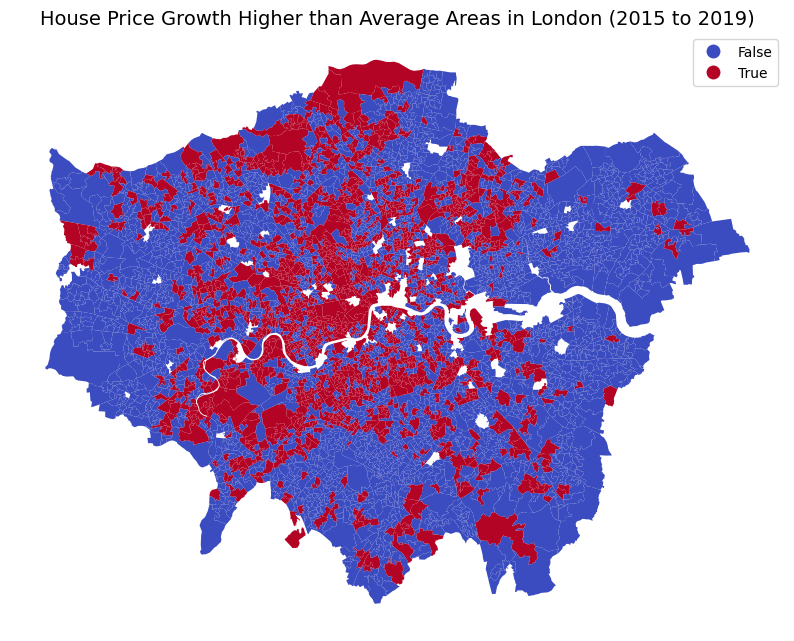

In [129]:
# show high house price areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_all_filled.plot(column='high_price_growth', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("House Price Growth Higher than Average Areas in London (2015 to 2019)", fontsize=14)
ax.axis('off')
plt.show()

As shown in the figure, the areas where house prices rising rate higher than the average are mainly concentrated in the outer London regions, such as East London and West London. The rate of increase in housing prices in the city center is relatively low, possibly because the growth potential is limited or the market itself is already sufficiently saturated.

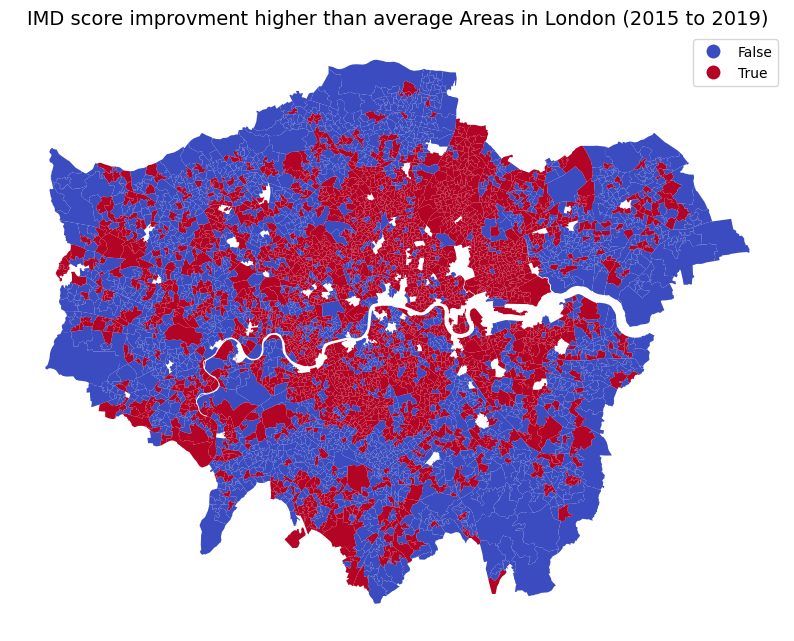

In [64]:
# show High imd scores areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_all_filled.plot(column='high_imd_improvement', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("IMD score improvment higher than average Areas in London (2015 to 2019)", fontsize=14)
ax.axis('off')
plt.show()

However, the regions where the improvement rate of the IMD index was higher than the average were mostly concentrated in the inner London area, showing an opposite trend to the result of house prices.

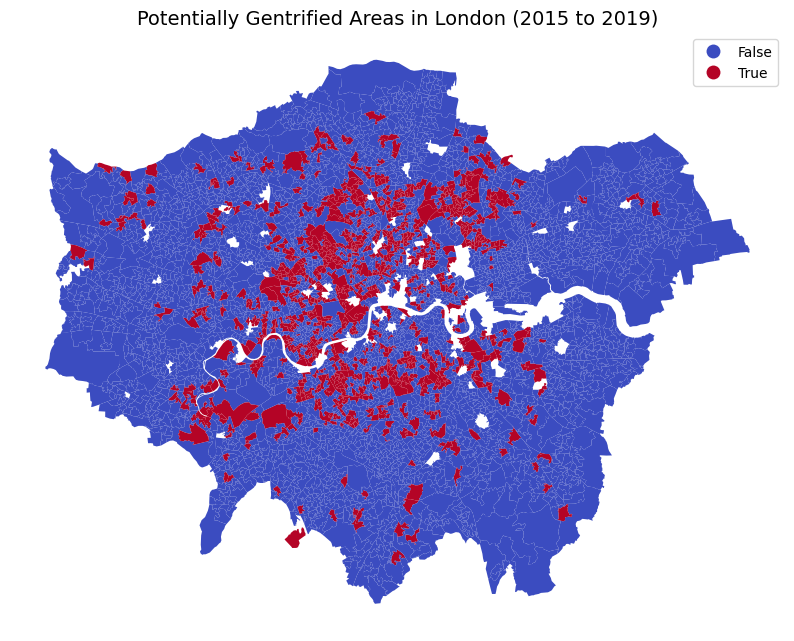

In [65]:
# show gentrified areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_all_filled.plot(column='gentrified', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Potentially Gentrified Areas in London (2015 to 2019)", fontsize=14)
ax.axis('off')
plt.show()

Based on the results of the previous two graphs, we can see that within the London area, the gentrification phenomenon does not show a centralized trend but is rather scattered and mainly distributed in the surrounding areas outside the core urban area.

In [66]:
london_all_filled.columns

Index(['LSOA code', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN',
       'HHOLDS', 'AVHHOLDSZ', 'geometry', '2010', '2019', 'centroid',
       '2010_final_knn', '2019_final_knn', 'IMD SCORE', 'LSOA name (2011)',
       'Index of Multiple Deprivation (IMD) Score', 'imd_score_improve',
       'price_growth', 'price_growth_rate', 'high_price_growth',
       'high_imd_improvement', 'gentrified'],
      dtype='object')

In [162]:
columns_to_keep = ['LSOA code', 'LSOA11NM', 'geometry', 'Index of Multiple Deprivation (IMD) Score', 
                   'gentrified']
london_gentri_labeled = london_all_filled[columns_to_keep]

In [163]:
london_gentri_labeled.to_file("data/gentri_data/london_gentri_labeled.shp")

C:\Users\hp\AppData\Local\Temp\ipykernel_18772\1298374198.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  london_gentri_labeled.to_file("data/gentri_data/london_gentri_labeled.shp")
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Index of Multiple Deprivation (IMD) Score' to 'Index of M'
  ogr_write(


In [164]:
# trying for the top 25%

price_growth_75 = london_all_filled['price_growth'].quantile(0.7)
imd_improve_75 = london_all_filled['imd_score_improve'].quantile(0.7)

# add labels for top 25%
london_all_filled['25_price_growth'] = london_all_filled['price_growth'] > price_growth_75
london_all_filled['25_imd_improvement'] = london_all_filled['imd_score_improve'] > imd_improve_75

# specific gentrified
london_all_filled[''] = london_all_filled['25_price_growth'] & london_all_filled['25_imd_improvement']
london_all_filled['gentrified2'] = london_all_filled['25_price_growth'] & london_all_filled['25_imd_improvement']
london_all_filled['gentrified2'].value_counts()

gentrified2
False    4095
True      547
Name: count, dtype: int64

In [ ]:
# # trying for the top 25%

# price_growth_75 = london_all_filled['price_growth'].quantile(0.75)
# imd_improve_75 = london_all_filled['imd_score_improve'].quantile(0.75)

# # add labels for top 25%
# london_all_filled['25_price_growth'] = london_all_filled['price_growth'] > price_growth_75
# london_all_filled['25_imd_improvement'] = london_all_filled['imd_score_improve'] > imd_improve_75

# # add labels for top 25%
# def classify(row):
#     if row['price_growth'] > price_growth_75 and row['imd_score_improve'] > imd_improve_75:
#         return 'gentrified2'
#     # elif row['price_growth'] > price_growth_75:
#     #     return 'high_price_only'
#     # elif row['imd_score_improve'] > imd_improve_75:
#     #     return 'imd_improvement_only'
#     else:
#         return 'non_gentrified'

# # specific gentrified
# london_all_filled['gentrified2'] = london_all_filled.apply(classify, axis=1)
# # london_all_filled['gentri_category'] = london_all_filled.apply(classify, axis=1)
# london_all_filled['gentrified2'].value_counts()

In [165]:
columns_to_keep2 = ['LSOA code', 'LSOA11NM', 'geometry',
                   'imd_score_improve', 'price_growth', 
                   '25_price_growth', '25_imd_improvement', 'gentrified2']
london_gentri_labeled25 = london_all_filled[columns_to_keep2]
london_gentri_labeled25.to_file("data/gentri_data/london_gentri_labeled_25_10_19.shp")

C:\Users\hp\AppData\Local\Temp\ipykernel_18772\3761836568.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  london_gentri_labeled25.to_file("data/gentri_data/london_gentri_labeled_25_10_19.shp")
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'imd_score_improve' to 'imd_score_'
  ogr_write(
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'price_growth' to 'price_grow'
  ogr_write(
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: '25_price_growth' to '25_price_g'
  ogr_write(
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: '25_imd_improvement

In [ ]:
# columns_to_keep2 = ['LSOA code', 'LSOA11NM', 'geometry',
#                    'imd_score_improve', 'price_growth', 
#                    'high_price_growth', 'high_imd_improvment', 'gentri_category']
# london_gentri_labeled25 = london_all_filled[columns_to_keep2]
# london_gentri_labeled25.to_file("data/gentri_data/london_gentri_labeled_25_only.shp")

In [ ]:
print(london_gentri_labeled25.columns)

Index(['LSOA code', 'LSOA11NM', 'geometry', 'imd_score_improve',
       'price_growth', '2019_final_knn', '25_price_growth',
       '25_imd_improvement', 'gentrified2'],
      dtype='object')


In [ ]:
# # show gentrified areas in map
# fig, ax = plt.subplots(figsize=(10, 10))
# london_all_filled.plot(column='gentri_cat', cmap='coolwarm', legend=True, ax=ax)
# ax.set_title("Areas Experienced Significant Improvement in Deprivation", fontsize=14)
# ax.axis('off')
# plt.show()

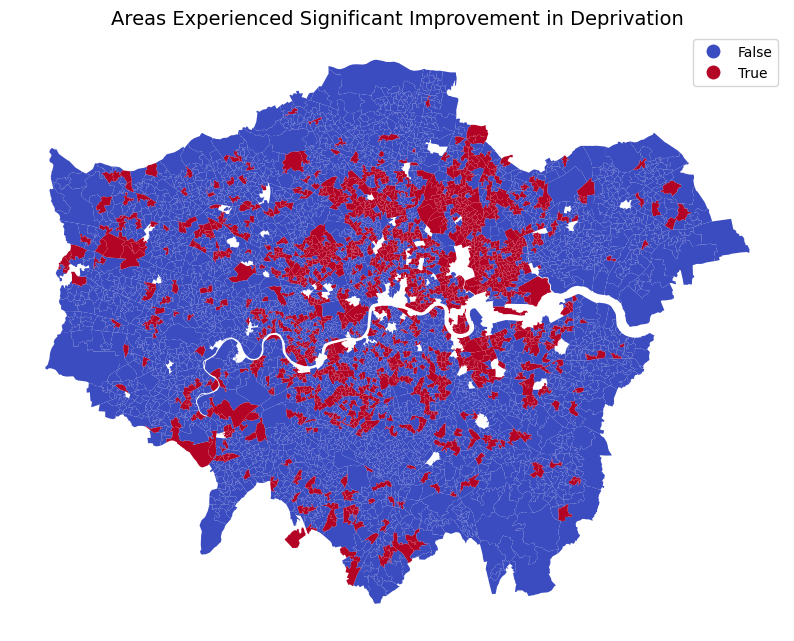

In [70]:
# show gentrified areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_all_filled.plot(column='25_imd_improvement', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Areas Experienced Significant Improvement in Deprivation", fontsize=14)
ax.axis('off')
plt.show()

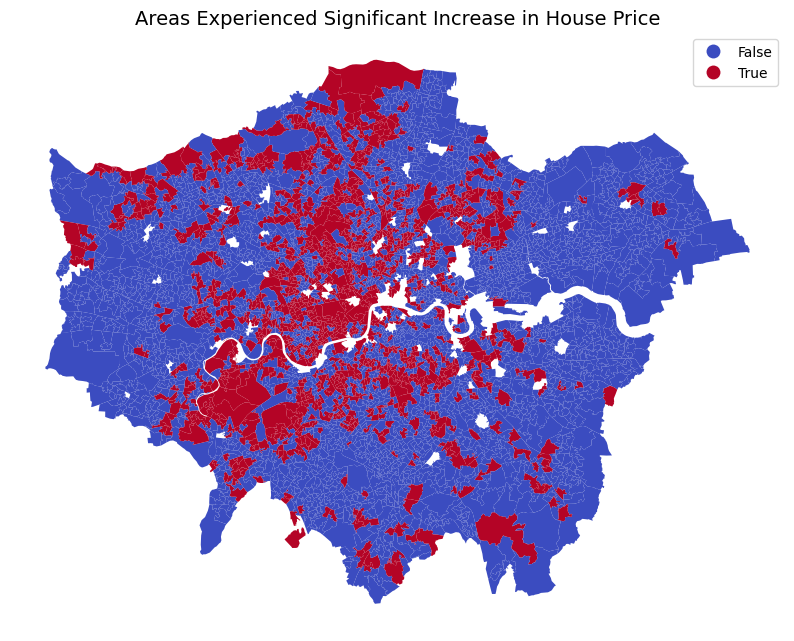

In [71]:
# show house areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_all_filled.plot(column='25_price_growth', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Areas Experienced Significant Increase in House Price", fontsize=14)
ax.axis('off')
plt.show()

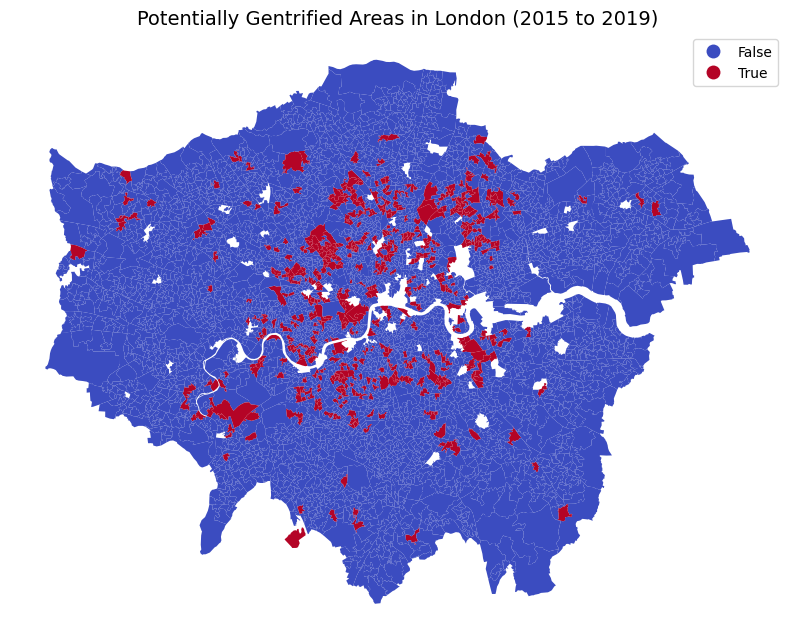

In [72]:
# show gentrified areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_all_filled.plot(column='gentrified2', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Potentially Gentrified Areas in London (2015 to 2019)", fontsize=14)
ax.axis('off')
plt.show()

## Try Clustering

In [69]:
features_for_clustering = ['imd_score_improve', 'price_growth', 'level_4_per', 'prof_occ_per',]

In [80]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(london_all_filled[features_for_clustering])

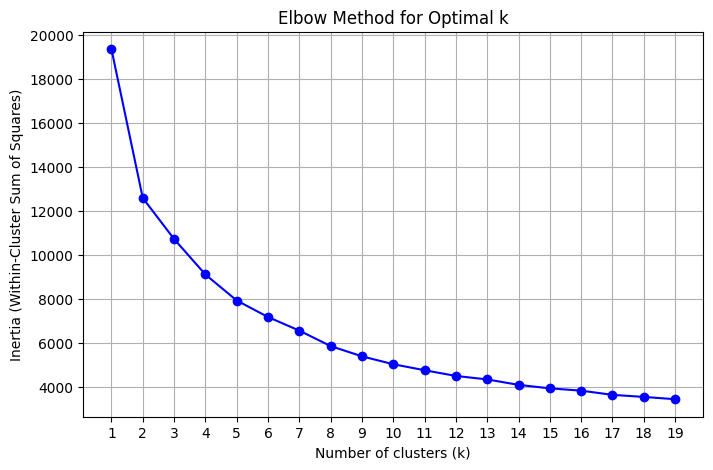

In [81]:
from sklearn.cluster import KMeans
# 3. 肘部法则计算
inertia = []
K_range = range(1, 20)  # 可自行扩大范围

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 4. 绘图
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [82]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

london_all_filled['gentri_cluster'] = clusters

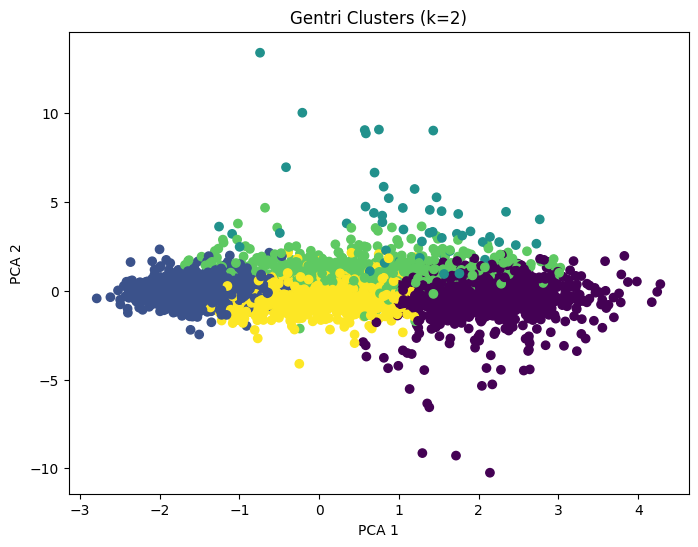

In [83]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Gentri Clusters (k=2)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


In [84]:
import pandas as pd

# 把聚类标签还原回原始变量
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                                columns=[features_for_clustering])

print(cluster_centers)

  imd_score_improve   price_growth level_4_per prof_occ_per
0          0.130665   10193.726589   57.766970    32.038081
1          0.045284   80074.507905   23.468739    13.743870
2          0.145257  926022.709119   54.918868    28.262264
3         -0.124862   70675.482885   43.550833    26.247361
4          0.141927   75340.002560   35.871947    21.503109


In [85]:
london_all_filled['gentrified3'] = (london_all_filled['gentri_cluster'] == 2).astype(int)
cluster_col_keep = ['LSOA code','gentrified3','gentri_cluster','geometry']
london_cludter = london_all_filled[cluster_col_keep]
print(london_cludter.columns)

Index(['LSOA code', 'gentrified3', 'gentri_cluster', 'geometry'], dtype='object')


In [86]:
london_cludter.to_file("data/gentri_data/london_gentri_labeled_clustering.shp")

C:\Users\hp\AppData\Local\Temp\ipykernel_30748\4089829898.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  london_cludter.to_file("data/gentri_data/london_gentri_labeled_clustering.shp")
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'gentrified3' to 'gentrified'
  ogr_write(
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'gentri_cluster' to 'gentri_clu'
  ogr_write(


In [87]:
from matplotlib.patches import Patch

# 自定义每个聚类的颜色
cluster_colors = {
    0: 'grey',
    1: 'grey',
    2: 'red',
    3: 'grey',
    4: 'grey'
}

# 可选：自定义每个类别的文字标签（按你的聚类中心结果来写）
cluster_labels = {
    0: 'decrease in house price',
    1: 'High Increse in House Price',
    2: 'decrease in imd improvment',
    3: 'Other',
    4: 'Potentially Gentri (relaticely high increase rate in houseprice and imd)',
    5: 'High house prive increase'
}
london_all_filled['cluster_color'] = london_all_filled['gentri_cluster'].map(cluster_colors)

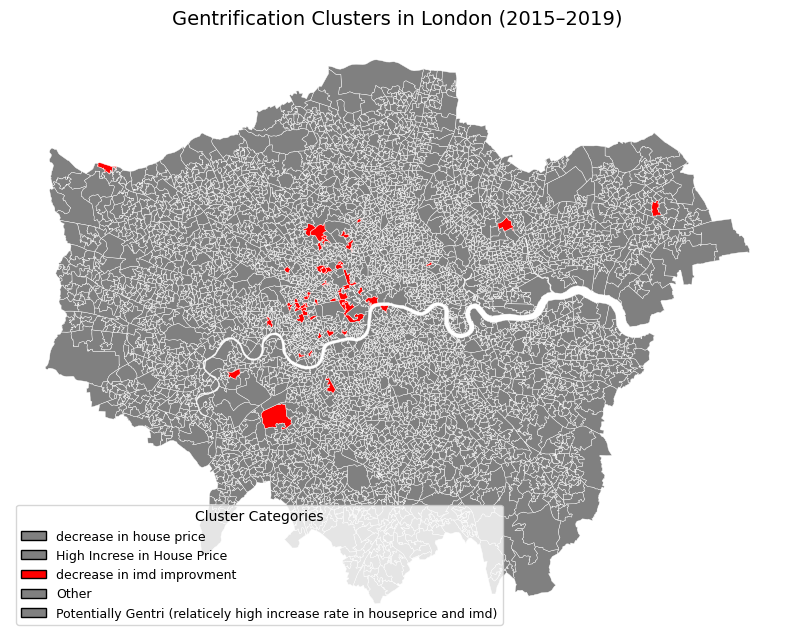

In [89]:
fig, ax = plt.subplots(figsize=(10, 10))

# 绘图，不使用默认 legend
london_all_filled.plot(color=london_all_filled['cluster_color'], ax=ax, edgecolor='white', linewidth=0.3)

# 构造图例元素
legend_elements = [
    Patch(facecolor=cluster_colors[i], edgecolor='black', label=cluster_labels[i]) for i in range(5)
]

# 添加图例
ax.legend(handles=legend_elements, title='Cluster Categories', loc='lower left', fontsize=9)
ax.set_title("Gentrification Clusters in London (2015–2019)", fontsize=14)
ax.axis('off')

plt.show()